In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf

In [79]:
tf.config.run_functions_eagerly(False)

In [2]:
import pathlib
data_dir = pathlib.Path('../Data/Obese/').with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1705


In [4]:
batch_size = 32
img_height = 150
img_width = 150

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split = 0.3, subset="training",seed=123,image_size=(img_height,img_width),batch_size=batch_size,label_mode='categorical'
)
steps_per_epoch = len(train_ds)//batch_size
#train_ds=train_ds.repeat()

Found 1705 files belonging to 5 classes.
Using 1194 files for training.


In [6]:
file_path = train_ds.file_paths

In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split = 0.3, subset="validation",seed=123,image_size=(img_height,img_width),batch_size=batch_size,label_mode='categorical'
)
validation_steps = len(val_ds)//batch_size
#val_ds = val_ds.repeat()

Found 1705 files belonging to 5 classes.
Using 511 files for validation.


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # Persentase data untuk validation set (tidak digunakan)
    subset="validation",   # Menggunakan subset validation set (sebagai test set)
    seed=42,               # Seed untuk random splitting
    image_size=(img_height,img_width), # Ukuran gambar yang diinginkan
    batch_size=batch_size,
    label_mode='categorical'
)

Found 1705 files belonging to 5 classes.
Using 511 files for validation.


In [9]:
class_name = val_ds.class_names
class_name

['normal', 'obese1', 'obese2', 'overweight', 'underweight']

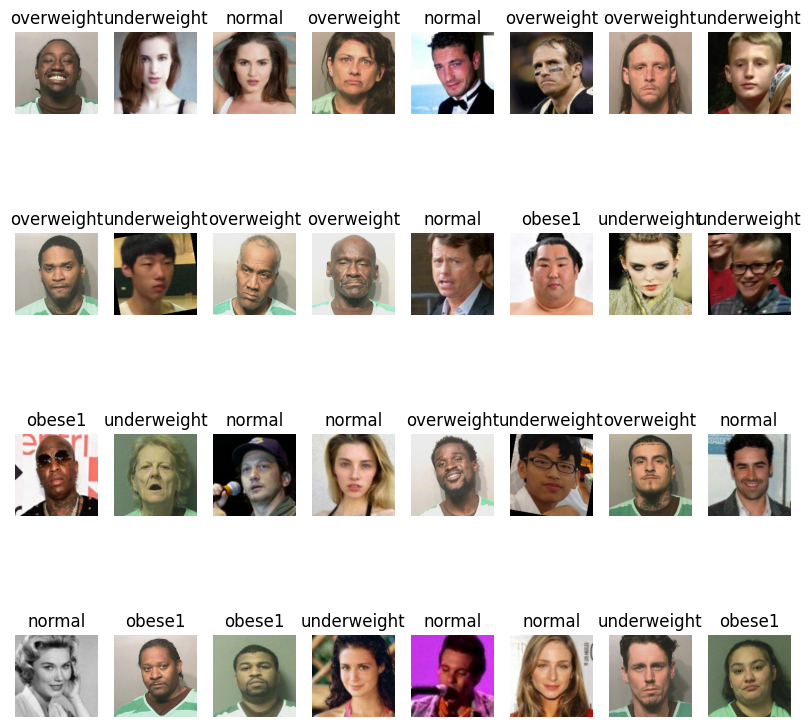

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(32):
        ax=plt.subplot(4,8,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_name[np.argmax(labels[i])])
        plt.axis('off')

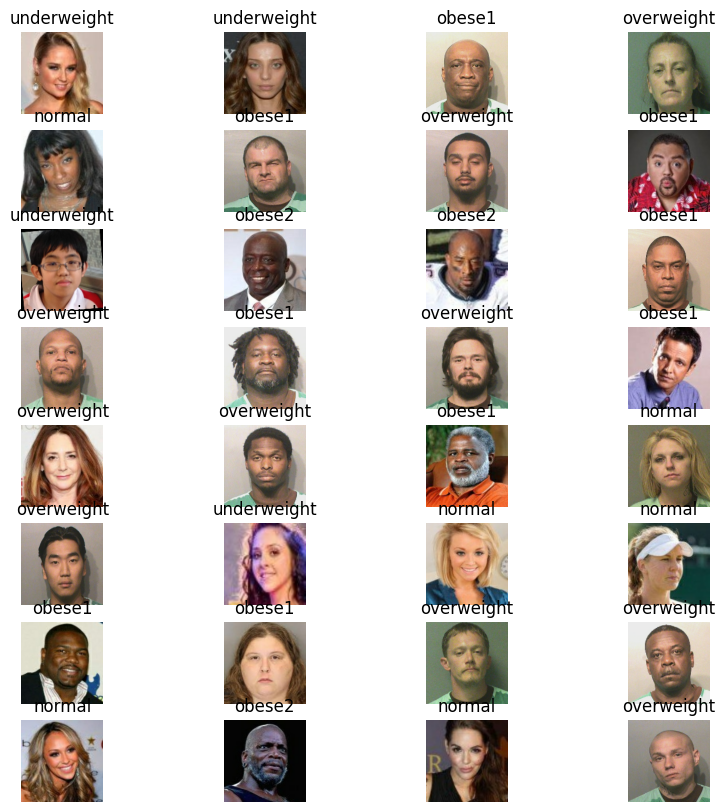

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in val_ds.take(1):
    for i in range(32):
        ax=plt.subplot(8,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_name[np.argmax(labels[i])])
        plt.axis('off')

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32, 5)


In [13]:
train_ds_aug = train_ds.map(lambda x,y: (tf.image.random_brightness(x,max_delta=0.4),y))
#train_ds_aug = train_ds.map(lambda x,y: (tf.image.random_contrast(x,lower=0.10,upper=1.5),y))

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotasi gambar dalam rentang 20 derajat
    width_shift_range=0.2,  # Perpindahan horizontal gambar
    height_shift_range=0.2,  # Perpindahan vertikal gambar
    shear_range=0.2,  # Peregangan gambar
    zoom_range=0.2,  # Perbesaran gambar
    horizontal_flip=True,  # Flip horizontal gambar
    fill_mode='nearest'  # Cara mengisi piksel kosong setelah augmentasi
)

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [16]:
normalized_train = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

2.1788699e-05 1.0


In [17]:
#normalized_train = normalized_train.repeat()

In [18]:
normalized_val = val_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_val))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


In [19]:
normalized_test = test_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_test))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.007699722 0.9853399


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
normalized_train_ds = normalized_train.prefetch(buffer_size=AUTOTUNE)#.cache(filename='cache')
normalized_val_ds = normalized_val.prefetch(buffer_size=AUTOTUNE)#.cache(filename='cache')#.prefetch(buffer_size=AUTOTUNE)

normalized_train_ds = normalized_train_ds.repeat()
#normalized_val_ds = normalized_val_ds.repeat()

In [99]:
normalized_test_ds = normalized_test.cache(filename='cache')#.prefetch(buffer_size=AUTOTUNE)

In [21]:
from tensorflow.keras.optimizers import Adam,RMSprop,Adagrad
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet import MobileNet
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  base_model = MobileNet(weights='imagenet', include_top=False)
  base_model.trainable = True
  for layer in base_model.layers[:100]:
    layer.trainable = False
# ``
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(5, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  #model = tf.keras.models.Sequential([ 
  #  tf.keras.layers.Rescaling(1./255),
  #    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
  #    tf.keras.layers.MaxPooling2D(2,2),
  #    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
  #    tf.keras.layers.MaxPooling2D(2,2),
  #    tf.keras.layers.MaxPooling2D(2,2),
  #    tf.keras.layers.Flatten(),
  #    tf.keras.layers.Dense(512,activation='relu'),
  #    tf.keras.layers.Dropout(0.5),
  #    tf.keras.layers.Dense(5,activation='softmax')
  #])

  
  model.compile(optimizer=Adagrad(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    
  ### END CODE HERE

  return model

In [23]:
model = create_model()

early_stopping = EarlyStopping(patience=5, verbose=1)
callbacks =[early_stopping]

history = model.fit(normalized_train_ds,
                    epochs=150,
                    verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=normalized_val,
                    #validation_steps=validation_steps
                    callbacks=callbacks
                    )

Epoch 1/150
1/1 [==============================] - 12s 12s/step - loss: 3.1760 - accuracy: 0.0312 - val_loss: 2.5667 - val_accuracy: 0.1194
Epoch 2/150
1/1 [==============================] - 6s 6s/step - loss: 3.0478 - accuracy: 0.0625 - val_loss: 2.3068 - val_accuracy: 0.1683
Epoch 3/150
1/1 [==============================] - 6s 6s/step - loss: 1.9957 - accuracy: 0.1875 - val_loss: 2.1887 - val_accuracy: 0.1840
Epoch 4/150
1/1 [==============================] - 6s 6s/step - loss: 2.2151 - accuracy: 0.0938 - val_loss: 2.1060 - val_accuracy: 0.2035
Epoch 5/150
1/1 [==============================] - 6s 6s/step - loss: 1.9154 - accuracy: 0.2812 - val_loss: 2.0334 - val_accuracy: 0.2153
Epoch 6/150
1/1 [==============================] - 5s 5s/step - loss: 2.1087 - accuracy: 0.2188 - val_loss: 1.9541 - val_accuracy: 0.2250
Epoch 7/150
1/1 [==============================] - 5s 5s/step - loss: 1.7721 - accuracy: 0.3125 - val_loss: 1.8834 - val_accuracy: 0.2485
Epoch 8/150
1/1 [===============

In [185]:
model.evaluate(normalized_test)

17/17 [==============================] - 7s 237ms/step - loss: 0.9907 - accuracy: 0.5730


[0.9906550049781799, 0.5730336904525757]

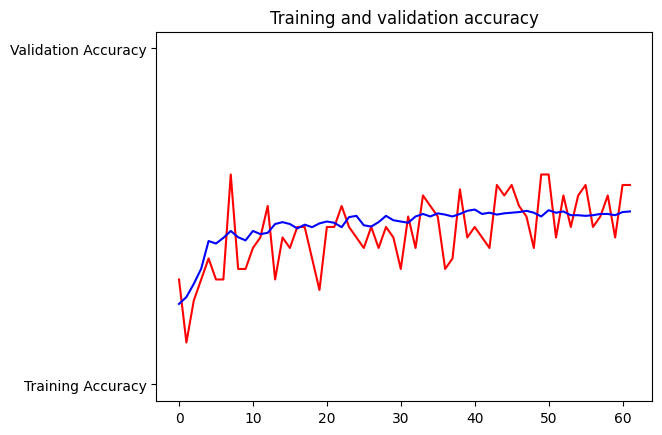

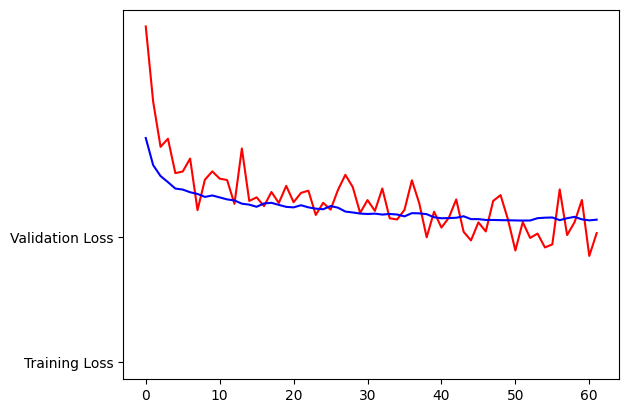

In [186]:
import matplotlib.pyplot as plt
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [102]:
tf.keras.Model.save(model,'../models/obese_models/6/')

INFO:tensorflow:Assets written to: ../models/obese_models/6/assets


INFO:tensorflow:Assets written to: ../models/obese_models/6/assets


In [103]:
model.save('../Models/obese_models/6/model.h5')

# CEK MODEL

In [227]:
import tensorflow as tf

model = tf.keras.models.load_model('../Models/obese_models/5/')

In [5]:
class_name = ['normal', 'obese1', 'obese2', 'overweight', 'underweight']

1/1 [==============================] - 0s 43ms/step
[[0.21534663 0.05660981 0.02998356 0.06039176 0.63766825]]
['normal', 'obese1', 'obese2', 'overweight', 'underweight']
status :underweight


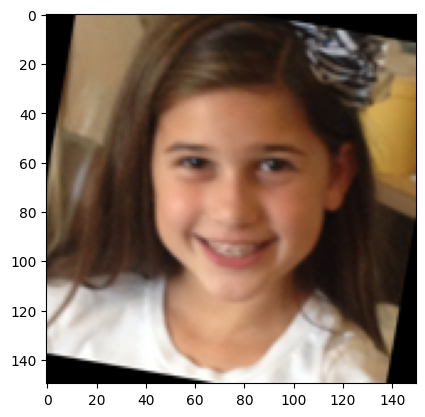

In [206]:
import matplotlib.pyplot as plt
import PIL
import numpy as np
img = PIL.Image.open('../Data/gender/female/coarse_tilt_aligned_face.187.8768495427_5171c91b0a_o.jpg')

img = img.resize((150,150))

image = np.array(img)/255.0
image = image.reshape((1,150,150,3))
predict = class_name[np.argmax(model.predict(image))]
print(model.predict(image))
print(class_name)
print(f'status :{predict}')
plt.imshow(img)

In [229]:
image = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/age/',
    image_size=(img_height, img_width),
)

Found 8400 files belonging to 6 classes.


In [232]:
predicted_labels = []
for images, _ in image:
    predictions = model.predict(images)
    predicted_labels.extend(predictions)


1/1 [==============================] - 1s 1s/step


IndexError: list index out of range

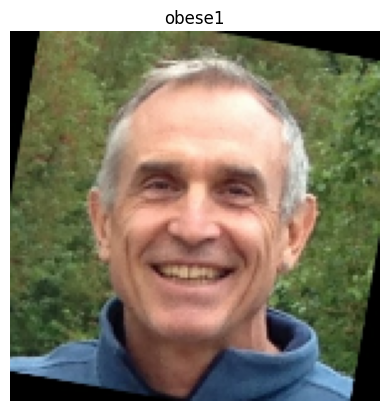

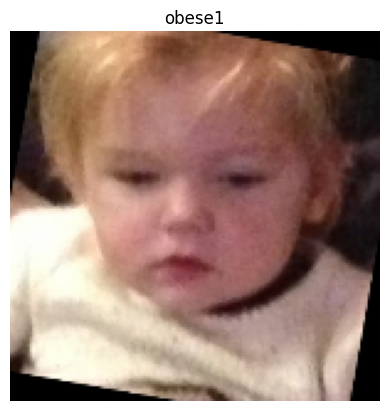

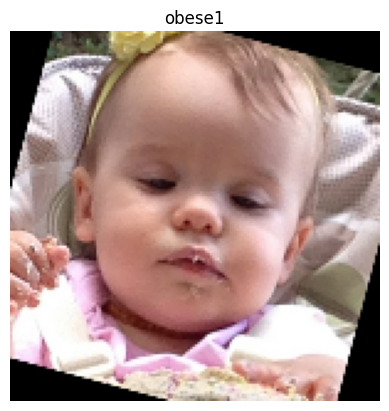

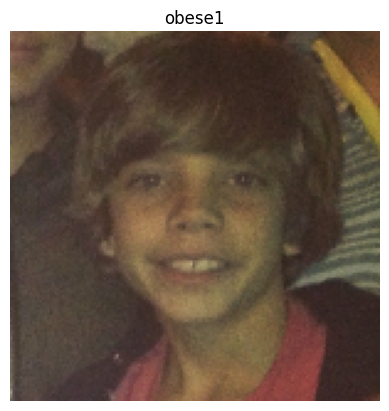

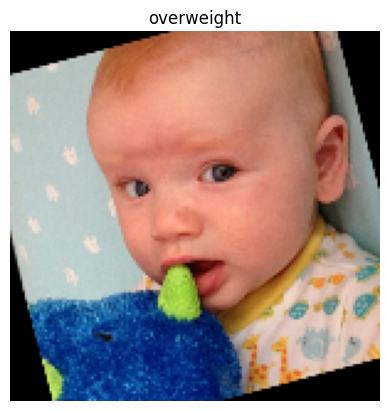

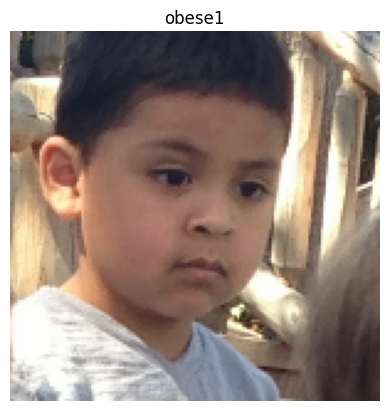

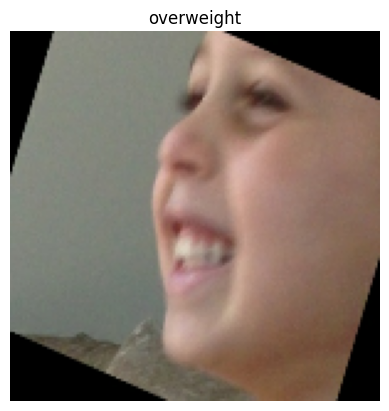

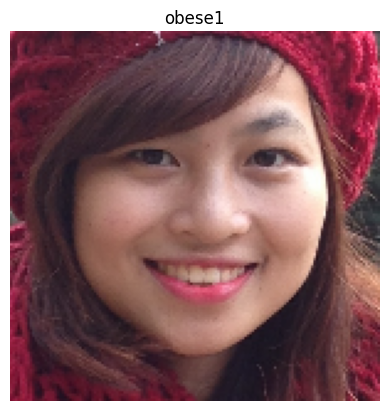

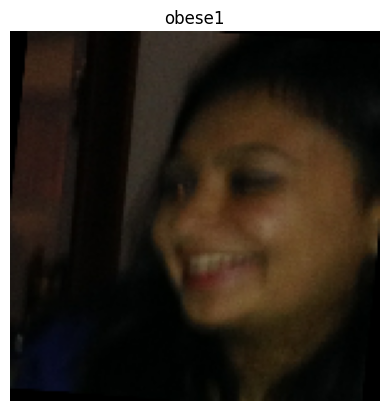

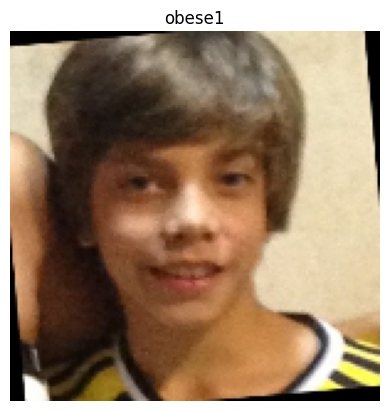

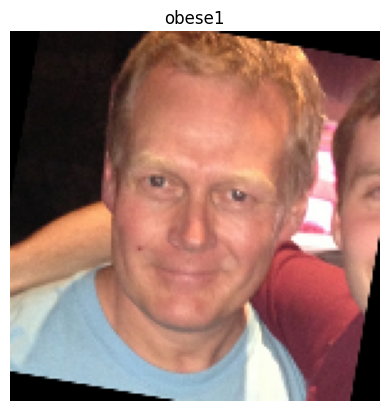

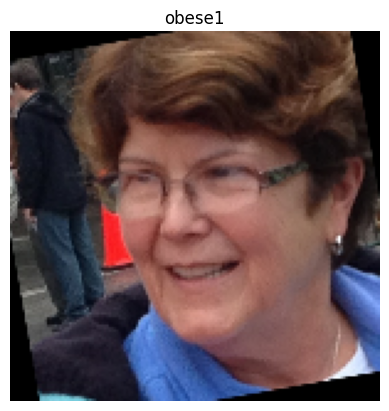

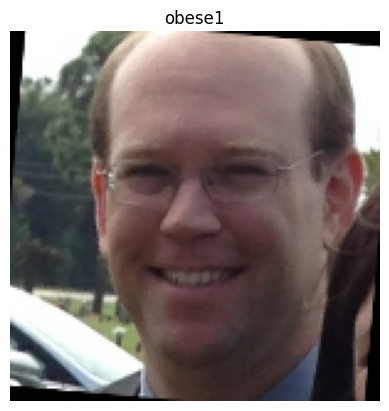

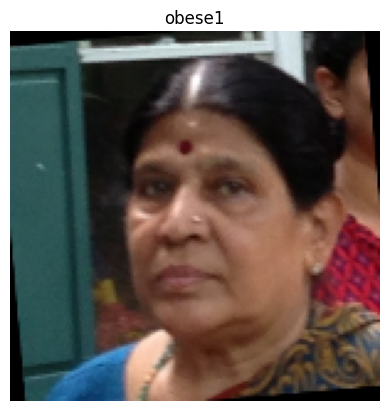

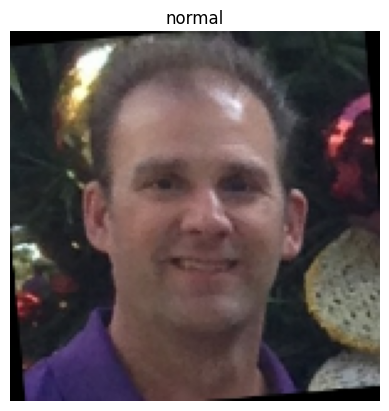

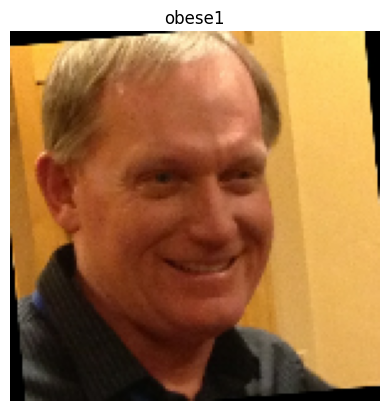

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 16 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [226]:
num_images_to_display = 32
for i in range(num_images_to_display):
    image = images[i]  # Get the i-th image from the batch
    predicted_label = np.argmax(predicted_labels[i])  # Get the index of the predicted label
    predicted_class = class_name[predicted_label]  # Get the predicted class label

    # Display the image with the predicted label
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(predicted_class)
    plt.axis("off")
    plt.show()

# ERROR ANALYSIS

In [210]:
image = normalized_val.list_files()

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: ../Data/Obese/*.jpg'

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>